In [5]:
#import necessary libraries 
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [6]:
#paths to data
mercury_albedo_top="/home/g0kul6/g0kul6/ml4sci/DATA/Data_Mercury/mercury-albedo-top-half.png.csv"
mercury_albedo_bottom="/home/g0kul6/g0kul6/ml4sci/DATA/Data_Mercury/mercury-albedo-resized-bottom-half.png.csv"
alsi_map="/home/g0kul6/g0kul6/ml4sci/DATA/Data_Mercury/alsimap_smooth_032015.png.csv"
casi_map="/home/g0kul6/g0kul6/ml4sci/DATA/Data_Mercury/casimap_smooth_032015.png.csv"
fesi_map="/home/g0kul6/g0kul6/ml4sci/DATA/Data_Mercury/fesimap_smooth_032015.png.csv"
mgsi_map="/home/g0kul6/g0kul6/ml4sci/DATA/Data_Mercury/mgsimap_smooth_032015.png.csv"
ssi_map="/home/g0kul6/g0kul6/ml4sci/DATA/Data_Mercury/ssimap_smooth_032015.png.csv"


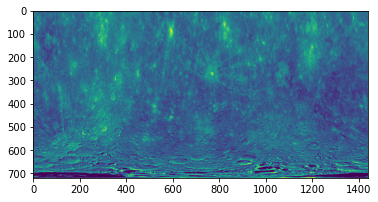

In [15]:
img=np.array(pd.read_csv(mercury_albedo_bottom))
# img=cv2.resize(img,(1440,1440))
# img=img[720:,:]
plt.imshow(img)
plt.show()

In [4]:
#custom dataset
class dataset(Dataset):
  def __init__(self,path_1,path_2,path_3,path_4,path_5,path_6):
    self.path_1=path_1
    self.path_2=path_2
    self.path_3=path_3
    self.path_4=path_4
    self.path_5=path_5
    self.path_6=path_6
    #converting the data to tensors
    self.X_1=torch.FloatTensor(np.array(pd.read_csv(path_1)))
    self.X_2=torch.FloatTensor(np.array(pd.read_csv(path_2)))
    self.X_3=torch.FloatTensor(np.array(pd.read_csv(path_3)))
    self.X_4=torch.FloatTensor(np.array(pd.read_csv(path_4)))
    self.X_5=torch.FloatTensor(np.array(pd.read_csv(path_5)))
    self.X_6=torch.FloatTensor(np.array(pd.read_csv(path_6)))
    #normalizing the data
    self.X_1=(self.X_1.flatten()-torch.mean(self.X_1.flatten()))/torch.std(self.X_1.flatten())
    self.X_2=(self.X_2.flatten()-torch.mean(self.X_2.flatten()))/torch.std(self.X_2.flatten())
    self.X_3=(self.X_3.flatten()-torch.mean(self.X_3.flatten()))/torch.std(self.X_3.flatten())
    self.X_4=(self.X_4.flatten()-torch.mean(self.X_4.flatten()))/torch.std(self.X_4.flatten())
    self.X_5=(self.X_5.flatten()-torch.mean(self.X_5.flatten()))/torch.std(self.X_5.flatten())
    self.X_6=self.X_6.flatten()
    self.Y=torch.stack((self.X_1,self.X_2,self.X_3,self.X_4,self.X_5),1)  
    self.X=self.X_6
  
  def __len__(self):
    self.filelength=len(self.Y)
    return self.filelength

  def __getitem__(self,idx):
    return self.X[idx],self.Y[idx]

In [5]:
data=dataset(alsi_map,casi_map,fesi_map,mgsi_map,ssi_map,mercury_albedo_top)
train_loader=DataLoader(dataset=data,batch_size=32,shuffle=True)
for x,y in train_loader:
    print(x)
    print(y)
    break

tensor([0.3020, 0.4196, 0.4196, 0.3333, 0.4275, 0.4118, 0.3882, 0.4431, 0.3412,
        0.6549, 0.2235, 0.3686, 0.3490, 0.4078, 0.3686, 0.4392, 0.4431, 0.1804,
        0.4863, 0.4549, 0.3059, 0.4588, 0.3725, 0.4667, 0.4000, 0.2902, 0.4667,
        0.5647, 0.3882, 0.3647, 0.4824, 0.3804])
tensor([[-0.5527,  0.8823,  1.7611,  1.2315,  1.7284],
        [-0.7914,  1.1436, -1.0871,  0.8724,  0.9276],
        [ 0.8996,  1.3875,  0.8117, -0.2326,  1.2684],
        [-0.0155,  0.3946,  0.6896,  0.7342,  0.6039],
        [ 0.0641,  0.4643,  0.6354,  0.3475,  0.5528],
        [ 0.7206,  0.2727,  0.8524,  0.0437,  0.1439],
        [ 0.2829, -1.8175, -1.0871, -0.6193, -1.6792],
        [ 0.3625, -1.8175, -1.0871,  0.3475, -1.6792],
        [ 0.7206,  0.4294,  1.1643, -0.0116,  0.3142],
        [ 0.8996,  0.4294, -1.0871, -0.6469,  0.0416],
        [ 0.6410,  0.3249,  0.9202,  0.1818,  0.2120],
        [ 0.1834, -1.8175, -1.0871, -0.4259, -1.6792],
        [ 0.1635,  0.4469,  0.5947,  0.4304,  0.484